In [211]:
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from collections import namedtuple
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt

In [300]:
Relation = namedtuple('relation', ['src', 'dst'])
Flow = namedtuple('flow', ['name', 'src', 'dst', 'function', 'policy'])

class Stock():
    count = 0
    
    def __init__(self, name, n):
        self.name = name
        self.count = n
    
    def __lshift__(self, other):
        return Relation(other, self)
    
    def __rshift__(self, other):
        return Relation(self, other)
    

class Nowhere(Stock):
    count = None
    name = "nowhere"
    def __init__(self):
        pass
        

class System:
    
    nowhere = None
    stocks = []
    flows = []
    
    def __init__(self):
        self.nowhere = Nowhere()
    
    
    def add_stock(self, name, n):
        stock = Stock(name, n)
        self.stocks.append(stock)
        return stock
    
    def gen_flow_policy(self, relation, function):
        def new_function(params, step, sL, s):
            y = function(s[relation.src.name], s[relation.dst.name], params[0], s)
            return {relation.dst.name: y,
                    relation.src.name: -y}
        return new_function
        
    def add_flow(self, name, relation, function=None):
        if function is None:
            function = lambda src, dst: src + dst
        policy = self.gen_flow_policy(relation, function)
        flow = Flow(name, *relation, function, policy)
        self.flows.append(flow)
        
        
    def gen_state_update(self, variable_name):
        def new_function(params, step, sL, s, _input):
            y = variable_name
            x = s[y] + _input[y]
            return (y, x)
        return new_function
            

    def generate_config(self, initial_state={}, sim_config={}, **kwargs):
        
        variables = {}
        state_update = {}
        variables['nowhere'] = np.inf
        for stock in self.stocks:
            variables[stock.name] = stock.count
            state_update[stock.name] = self.gen_state_update(stock.name)
        state_update['nowhere'] = lambda params, step, sL, s, _input: ('nowhere', np.inf)
            
        
        policies = {}
        for flow in self.flows:
            policies[flow.name] = flow.policy
            
        partial_state_update_blocks = [{"policies": policies,
                                        "variables": state_update
                                       }]
            
        config = Configuration(initial_state=variables,
                               partial_state_update_blocks=partial_state_update_blocks,
                               sim_config=sim_config)
        return config

    
    def run(self, T=100, N=1, params={}):
        
        sim_config = {'T': range(T),
                      'N': N,
                      'M': params}
        
        
        config = self.generate_config(sim_config=sim_config)
        exec_mode = ExecutionMode()
        exec_context = ExecutionContext(exec_mode.single_proc)
        executor = Executor(exec_context, [config]) 
        raw_result, tensor = executor.execute() 
        return raw_result


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7f12c89f5d68>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f12c89f5d68>]


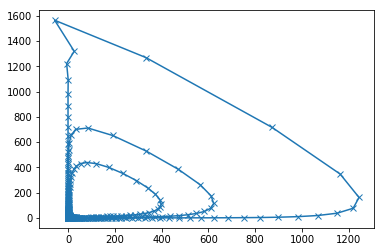

In [308]:
s = System()

nowhere = s.nowhere
prey = s.add_stock('prey', 100)
predator = s.add_stock('predator', 10)

dt = 0.1
params = {'prey_birth_rate': 1.0 * dt,
          'predator_birth_rate': 0.0 * dt,
          'prey_death_rate': 0.03 * dt,
          'predator_death_rate': 1.0 * dt,
          'prey_predator_interaction': 0.01 * dt}

s.add_flow('1', nowhere >> prey, lambda src, dst, params, s: dst * params['prey_birth_rate'])
s.add_flow('2', nowhere >> predator, lambda src, dst, params, s: dst * params['predator_birth_rate'])
s.add_flow('3', predator >> nowhere, lambda src, dst, params, s: src * params['predator_death_rate'])
s.add_flow('4', prey >> nowhere, lambda src, dst, params, s: src * params['prey_death_rate'])
s.add_flow('5', prey >> predator, lambda src, dst, params, s: src * dst * params['prey_predator_interaction'])

results = pd.DataFrame(s.run(T=300, params=params))
plt.plot(results.prey, results.predator, '-x')
plt.show()

In [197]:
import pandas as pd

nowhere          prey      predator  run  substep  timestep
0        inf  1.000000e+02  1.000000e+01    1        0         0
1        inf  1.100000e+02  2.000000e+01    1        1         1
2        inf  1.210000e+02  4.000000e+01    1        1         2
3        inf  1.331000e+02  8.000000e+01    1        1         3
4        inf  1.464100e+02  1.600000e+02    1        1         4
..       ...           ...           ...  ...      ...       ...
96       inf  9.412344e+05  7.922816e+29    1        1        96
97       inf  1.035358e+06  1.584563e+30    1        1        97
98       inf  1.138894e+06  3.169127e+30    1        1        98
99       inf  1.252783e+06  6.338253e+30    1        1        99
100      inf  1.378061e+06  1.267651e+31    1        1       100

[101 rows x 6 columns]

In [60]:
s